# 16 Land cover statistics

## About the data

In this lesson we will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. We will access this data through the [Microsoft Planetary Computer (MPC) data catalog](https://planetarycomputer.microsoft.com/dataset/gap). The class names and corresponding codes have been saved to a separete CSV to simplify access in this lesson. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).


The second dataset is a shapefile with the perimeters for 2017 California fires. This data was extracted from the CALFIRE's [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/about).

## Import auxiliary geometries

Let's start by importing the necessary libraries:

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Then import and select the Thomas Fire within the fire perimeters data:

<Axes: >

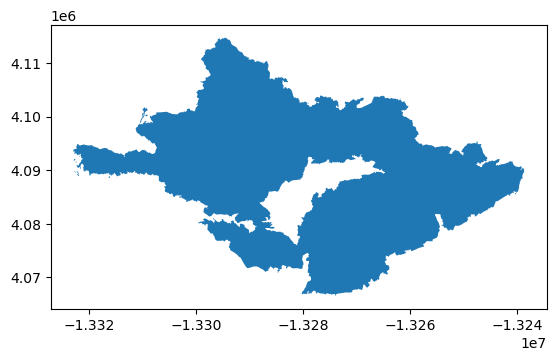

In [4]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA

fire_perimeters = gpd.read_file(os.path.join('data',
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017.shp'
                 ))
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Examine fire perimeter data
thomas_fire.crs
thomas_fire.plot()

And import the CA state perimeter:

<Axes: >

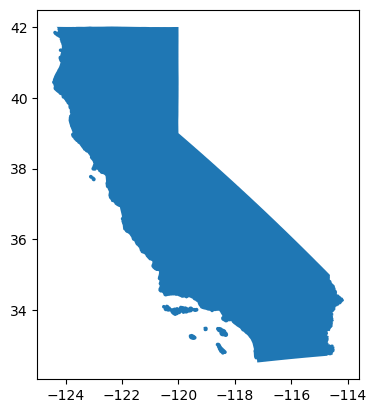

In [5]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA
ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))
ca.plot()

And import the lables for the GAP Terrestrial Ecosystems Data:

In [6]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA
labels = pd.read_csv(os.path.join('data',
                                  'GAP_National_Terrestrial_Ecosystems.csv')
                                  )
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


## Catalog search

Our goal is to retrieve the National Terrestrial Ecosystems data over the fire perimeter. In the [last lesson](/book/chapters/lesson-16-STAC.qmd) we used GeoJSON-type dictionary to do the catalog search. Here we will use a list `[xmin, ymin, xmax, ymax]` with the coordinate values defining the four corners of the region we want to search data over. Just as the GeoJSON, these coordinates have to be in the EPSG:4326 CRS. 

Our bounding box will come from the Thomas Fire perimeter. Notice we use method chaining to reproject and extract the bounds.

In [ ]:

# Create list of bounding box coords for search in 4326 CRS
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326') 
                                   .total_bounds
                                    )
thomas_fire_bbox

[-119.68162520650904,
 34.27989979600195,
 -118.92518097019486,
 34.63745683414112]

Next, we connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for the National Terrestrial Ecosystems data is `gap`:

In [8]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog 
search = catalog.search(collections=['gap'], 
                        bbox=thomas_fire_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 1 Items


In [9]:
# Select unique search item
item = items[0]  

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href, width=600)

In [10]:
labels = pd.read_csv(os.path.join('data',
                                  'GAP_National_Terrestrial_Ecosystems.csv')
                                  )
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


In [15]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Notice that `band` is dimension of length 1. We can go ahead and "squeeze" the raster to simplify it:

In [12]:
# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Sizes of dimensions:", dict(lulc.sizes))

Sizes of dimensions: {'y': 10000, 'x': 10000}


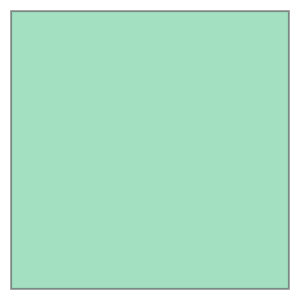

In [17]:
# Explore raster located with respect to California
box(*lulc.rio.bounds())

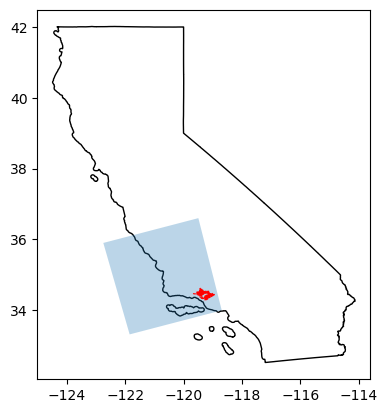

In [18]:
# Create GeoDataFrame from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                             crs = lulc.rio.crs)

ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))

# ------------------------------------------------------------------
# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor ='black')

# Reproject lulc_bbox and fire perimeter to match CA crs
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)  
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()

# Clip raster to geometry
In our first lesson about rasters we saw how to clip a raster to a rectangular region. In our case, we want to clip the raster exactly to the fire perimeter. Clipping can be a costly operation for such a big raster relative to a detailed geometry. So we will perform the clipping in two steps:

1. Clip the raster using the fire perimeter bounding box using rio.clip_box() and then
2. Clip the simplified raster to the fire perimeter using rio.clip().

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


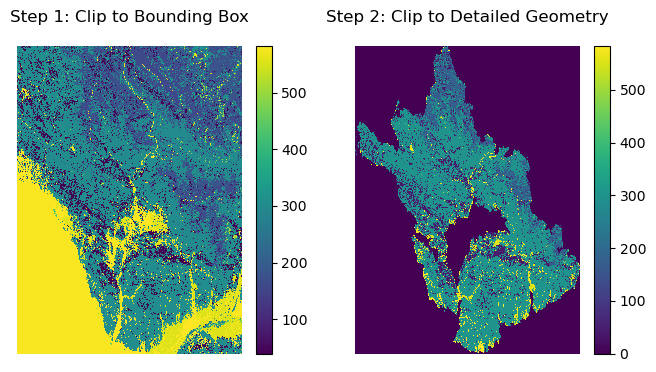

In [14]:
# Match CRSs and verify update
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

# Clip large raster to detailed geometry in two steps
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)
lulc_step2 = lulc_step1.rio.clip(thomas_fire_match.geometry)  # Produces RuntimeWarning

# ------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first clipped raster
lulc_step1.plot(ax=ax[0])
ax[0].set_title("Step 1: Clip to Bounding Box")
ax[0].axis("off")

# Plot the second clipped raster
lulc_step2.plot(ax=ax[1])
ax[1].set_title("Step 2: Clip to Detailed Geometry")
ax[1].axis("off")

plt.show()

# Raster no-data values
Notice a warning appeared when we clipped the raster. After some investigation, we will find that this RuntimeWarning occurs because the rio.clip() function tries to replace values outside the fire perimeter geometry with np.nan. However, as we previously saw, our raster’s data type is uint16 (16 bits unsigned integer). The cast issue appears since np.nan is a float (decimal number) and it cannot be casted as a uint16. To make sure the clipping function fills in any pixels with the adequate no-data value, let’s manually set it:

In [20]:
print('Original no-data value: ', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Original no-data value:  None
Updated no-data value:  0


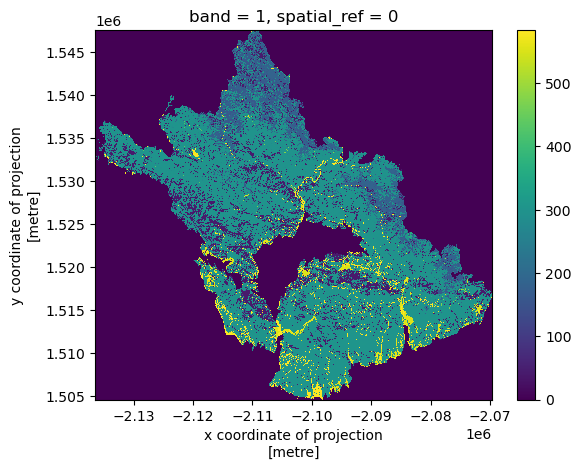

In [21]:
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
                 .rio.clip(thomas_fire_match.geometry)
                 )

# Examine results
lulc_clip.plot()                                  

In [ ]:
np.unique(lulc_clip, return_counts=True)

(array([  0,  39,  40,  41,  42,  43,  45,  55, 159, 162, 165, 183, 277,
        278, 282, 296, 297, 300, 302, 303, 304, 305, 359, 360, 383, 385,
        432, 470, 472, 485, 489, 516, 539, 540, 547, 552, 553, 556, 557,
        558, 567, 568, 578, 579, 581, 582, 583, 584], dtype=uint16),
 array([1927870,    6856,     361,  133704,    3638,   23150,    2907,
           4974,    3727,   60203,    5102,   75925,     378,   11098,
             29,      98,   64072,   69700,  183963,  454489,   88504,
            799,     750,     684,      28,      90,     865,     262,
           1329,      54,      44,      27,     298,      24,      15,
             43,       7,   18996,    2181,     485,      13,      20,
             10,    1858,   40653,    3782,     829,      58]))

In [33]:
print(labels.head())
pix_counts.head()

                           class_label  code
0                                    0     0
1          South Florida Bayhead Swamp     1
2           South Florida Cypress Dome     2
3  South Florida Dwarf Cypress Savanna     3
4         South Florida Mangrove Swamp     4


,pixels,number_pixels
0,0,1927870
1,39,6856
2,40,361
3,41,133704
4,42,3638


In [42]:
d = {'code' : pd.Series(np.unique(lulc_clip, return_counts=True)[0]),
     'n_pixels' : np.unique(lulc_clip, return_counts=True)[1],
     }

pix_counts = pd.DataFrame(d)

In [44]:
classes = pd.merge(labels, pix_counts, on='code')

In [45]:
classes

,class_label,code,n_pixels
0,0,0,1927870
1,California Central Valley Mixed Oak Savanna,39,6856
2,California Coastal Closed-Cone Conifer Forest ...,40,361
3,California Coastal Live Oak Woodland and Savanna,41,133704
4,California Lower Montane Blue Oak-Foothill Pin...,42,3638
5,Central and Southern California Mixed Evergree...,43,23150
6,Southern California Oak Woodland and Savanna,45,2907
7,Mediterranean California Mixed Evergreen Forest,55,4974
8,California Montane Jeffrey Pine-(Ponderosa Pin...,159,3727
9,Mediterranean California Dry-Mesic Mixed Conif...,162,60203


In [53]:
classes[classes['class_label'].str.contains("Developed")]['n_pixels'].sum()

45322

In [ ]:
total_pixels 